# Condition Robustness
We want to analyse the robustness with the updated error bounds considering the supremum of the derivative.

In [106]:
import numpy as np
from numpy.linalg import matrix_rank, svd
import sys
sys.path.append('../')
from test_data import experiment_data,add_noise,create_data_2d
import pysindy as ps
import matplotlib.pyplot as plt
from error_bounds import *

## Condition $\frac{\sigma_1}{\sigma_n}$

We consider the condition 
\begin{equation}
    k: S \rightarrow \mathbb{R}, k(A) = \frac{\sigma_1}{\sigma_n}
\end{equation}
where  $m\geq n, S=\{A\in\mathbb{R}^{m\times n}|A\text{ has full rank }n\}$. Because of the mean value theorem we now $|k({\tilde {A}})-k(A)| \leq  {\|{\tilde {A}}-A\|}\sup_{A'\in[A,\tilde{A}]} \|Dk(A')\|_F $. This implies for $\sigma_n-\|E\|_F>0$
$$    | \frac{\sigma_1(A+E)}{\sigma_n(A+E)} - \frac{\sigma_1(A)}{\sigma_n(A)} | 
    \leq \frac{\|E\|_F}{\sigma_n-\|E\|_F}\sqrt{ 1+\frac{\sigma_1+\|E\|_F}{\sigma_n-\|E\|_F}^2 }$$

This bound is only valid of $\sigma_n - \|E\|_F >0$ which might not be the case for $\sigma_n$  small.

In [2]:
# This calculates the above given bound
"""
sv_max: maximal singular value
sv_min: minimal singular value
eps: bound for Frobenius norm of noise matrix: ||E||_F <= eps
"""
def error_bound_condition(omax,omin,eps):
    if omin-eps>0:
        return eps/(omin-eps)*np.sqrt(1+((omax+eps)/(omin-eps))**2)
    else:
        return np.infty

In [3]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -5,1
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
print(alpha)
matrix[:,0] = alpha*matrix[:,2]
print(matrix)

sv = svd(matrix, compute_uv=False)
sv_max = sv[0]
sv_min = sv[-1]
print(f"matrix shape: {matrix.shape}, rank: {matrix_rank(matrix)}" )
print(f"Singular values : {sv}" )
print(f"Condtion big/smallest singular value: {sv[0]/sv[-1]}")
print(f"Bound: {error_bound_condition(sv_max,sv_min,0)}")

0.7349383006946869
[[-1.56480932 -0.19480374 -2.129171  ]
 [-2.08841686 -2.82611632 -2.84162203]
 [ 0.45251615  0.85138552  0.61571991]
 [-1.17109753 -2.80124656 -1.59346373]
 [-0.27701558 -1.87605422 -0.37692358]
 [-1.38123691 -1.28070697 -1.87939165]
 [-3.04839264 -1.44141589 -4.14782117]
 [-2.84450106 -0.82443426 -3.87039437]
 [-2.69408377 -3.53484146 -3.66572782]
 [-0.50073323 -0.10095575 -0.68132689]]
matrix shape: (10, 3), rank: 2
Singular values : [1.12433122e+01 3.34027969e+00 2.85094142e-16]
Condtion big/smallest singular value: 3.943719122400479e+16
Bound: 0.0


In [4]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t matrix rank \t sv \t \t \t \t \t  ratio \t bound  \t diff")
differences =[]
bounds =[]
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio = sv[0]/sv[-1]
    bound=error_bound_condition(sv_max,sv_min,np.linalg.norm(noise))
    differences.append(np.abs(ratio-sv_max/sv_min))
    bounds.append(bound)
    print(f" {target_noise}\t \t {matrix_rank(matrix_noise)} \t \t {sv} \t {ratio:3.3e}  \t {bound:3.3e}\t {np.abs(ratio-sv_max/sv_min):3.3e}")

Noise level 	 matrix rank 	 sv 	 	 	 	 	  ratio 	 bound  	 diff
 0	 	 2 	 	 [1.12433122e+01 3.34027969e+00 2.85094142e-16] 	 3.944e+16  	 0.000e+00	 0.000e+00
 1e-10	 	 3 	 	 [1.12433122e+01 3.34027968e+00 4.95187282e-10] 	 2.271e+10  	 inf	 3.944e+16
 1e-09	 	 3 	 	 [1.12433122e+01 3.34027969e+00 6.44531528e-09] 	 1.744e+09  	 inf	 3.944e+16
 1e-08	 	 3 	 	 [1.12433122e+01 3.34027973e+00 7.28297512e-08] 	 1.544e+08  	 inf	 3.944e+16
 1e-07	 	 3 	 	 [1.12433124e+01 3.34027995e+00 5.81872651e-07] 	 1.932e+07  	 inf	 3.944e+16
 1e-06	 	 3 	 	 [1.12433089e+01 3.34027842e+00 5.37636785e-06] 	 2.091e+06  	 inf	 3.944e+16
 1e-05	 	 3 	 	 [1.12433172e+01 3.34028007e+00 4.27033649e-05] 	 2.633e+05  	 inf	 3.944e+16
 0.0001	 	 3 	 	 [1.12434608e+01 3.34015647e+00 7.86844186e-04] 	 1.429e+04  	 inf	 3.944e+16
 0.001	 	 3 	 	 [1.12412019e+01 3.34276955e+00 4.94198586e-03] 	 2.275e+03  	 inf	 3.944e+16
 0.01	 	 3 	 	 [11.26154344  3.33529253  0.0420386 ] 	 2.679e+02  	 inf	 3.944e+16
 0.1	 	 3 	 	

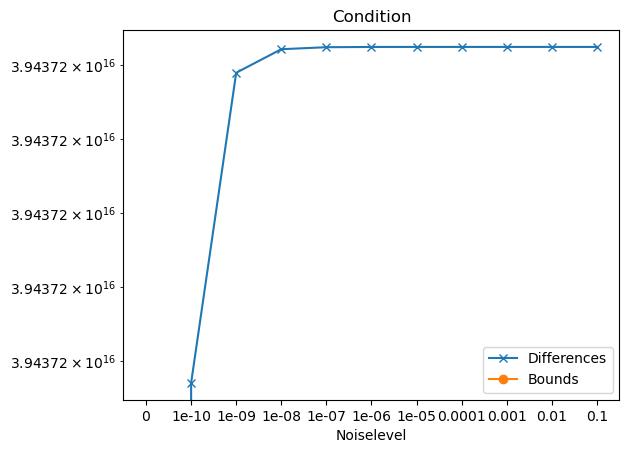

In [5]:
plt.title("Condition")
plt.plot(differences,marker='x',label="Differences")
plt.plot(bounds,marker='o',label="Bounds")
plt.xticks(np.arange(len(noise_levels)),noise_levels)
plt.yscale('log')
plt.xlabel('Noiselevel')
plt.legend()

Since for matrix with not full rank the bound is very high, I want to test the deviation for the same noise level

In [6]:
trials=10
noise_level=1e-1
differences=[]
bounds=[]
print(f"Noise level:  {noise_level}, Number trials: {trials}, True ratio: {sv_max/sv_min}")
print("Trial \t matrix rank \t sv \t \t \t \t \t  ratio \t  bound \t difference")
for trial in range(trials):
    var = noise_level * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio=sv[0]/sv[-1]
    bound = error_bound_condition(sv_max,sv_min,np.linalg.norm(noise))
    bounds.append(bound)
    differences.append(np.abs(ratio-sv_max/sv_min))
    print(f" {trial}\t \t {matrix_rank(matrix_noise)} \t {sv}\t  {ratio:3.3e}   \t {bound:3.3e} \t  {np.abs(ratio-sv_max/sv_min):3.3e}")

Noise level:  0.1, Number trials: 10, True ratio: 3.943719122400479e+16
Trial 	 matrix rank 	 sv 	 	 	 	 	  ratio 	  bound 	 difference
 0	 	 3 	 [11.37599336  3.49724717  0.61311385]	  1.855e+01   	 inf 	  3.944e+16
 1	 	 3 	 [11.50320342  3.01085961  0.70256762]	  1.637e+01   	 inf 	  3.944e+16
 2	 	 3 	 [11.53403946  3.38863663  0.50170512]	  2.299e+01   	 inf 	  3.944e+16
 3	 	 3 	 [11.22329168  3.42992991  0.7222164 ]	  1.554e+01   	 inf 	  3.944e+16
 4	 	 3 	 [11.134499    3.36533712  0.46983784]	  2.370e+01   	 inf 	  3.944e+16
 5	 	 3 	 [11.28089465  3.58803774  0.82217168]	  1.372e+01   	 inf 	  3.944e+16
 6	 	 3 	 [11.46578747  3.67974853  0.55392302]	  2.070e+01   	 inf 	  3.944e+16
 7	 	 3 	 [11.31701894  3.34658941  0.79093374]	  1.431e+01   	 inf 	  3.944e+16
 8	 	 3 	 [10.83261205  3.36938485  0.6978216 ]	  1.552e+01   	 inf 	  3.944e+16
 9	 	 3 	 [10.50305246  3.56235721  0.58305259]	  1.801e+01   	 inf 	  3.944e+16


## Reversed condition $\frac{\sigma_n}{\sigma_1}$

We consider the function reversed condition 
\begin{equation}
    r: \mathbb{R}^{m\times n} / \{0\} \rightarrow \mathbb{R}, r(A) = \frac{\sigma_n}{\sigma_r}
\end{equation}
where  $m\geq n$. Because of the mean value theorem we now $|r({\tilde {A}})-r(A)| \leq  {\|{\tilde {A}}-A\|}\sup_{A'\in[A,\tilde{A}]} \|Dr(A')\|_F $. This implies for $\sigma_1-\|E\|_F>0$
$$    | \frac{\sigma_n(A+E)}{\sigma_1(A+E)} - \frac{\sigma_n(A)}{\sigma_1(A)} | 
    \leq \frac{\|E\|_F}{\sigma_1-\|E\|_F}\sqrt{ 1+\frac{\sigma_n+\|E\|_F}{\sigma_1-\|E\|_F}^2 }$$
Can we maybe also found a lower bound for this?

### Reversed condition: Error bounds

In [7]:
# This calculates the above given bound
"""
sv_max: maximal singular value
sv_min: minimal singular value
eps: bound for Frobenius norm of noise matrix: ||E||_F <= eps
"""
def error_bound_rev_condition(omax,omin,eps):
    assert(omax-eps>0)
    return eps/(omax-eps)*np.sqrt(1+((omin+eps)/(omax-eps))**2)


In [8]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -5,1
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
print(alpha)
matrix[:,0] = alpha*matrix[:,2]
print(matrix)
sv = svd(matrix, compute_uv=False)
sv_max = sv[0]
sv_min = sv[-1]
print(f"matrix shape: {matrix.shape}, rank: {matrix_rank(matrix)}" )
print(f"Singular values : {sv}" )
print(f"Condtion big/smallest singular value: {sv[-1]/sv[0]}")
print(f"Bound: {error_bound_condition(sv_max,sv_min,0)}")

0.7053794481176904
[[-0.94067835 -3.74919742 -1.33357777]
 [-0.64571052  0.99750179 -0.91540875]
 [-0.97344523 -4.32510177 -1.38003061]
 [-1.06576669 -1.24484499 -1.5109126 ]
 [-0.87310792 -4.3222538  -1.23778474]
 [-1.0925862   0.51987975 -1.54893399]
 [-1.92302627 -0.01709818 -2.72622951]
 [-1.28813972 -3.73355587 -1.82616566]
 [-2.90852302  0.76433202 -4.12334528]
 [ 0.47481892 -4.05608636  0.67313971]]
matrix shape: (10, 3), rank: 2
Singular values : [9.85080505e+00 6.82188982e+00 5.23813205e-16]
Condtion big/smallest singular value: 5.3174659579208474e-17
Bound: 0.0


In [9]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t matrix rank \t sv \t \t \t \t \t  ratio \t bound  \t diff")
differences =[]
bounds =[]
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio = sv[-1]/sv[0]
    bound=error_bound_rev_condition(sv_max,sv_min,np.linalg.norm(noise))
    differences.append(np.abs(ratio-sv_min/sv_max))
    bounds.append(bound)
    print(f" {target_noise}\t \t {matrix_rank(matrix_noise)} \t \t {sv} \t {ratio:3.3e}  \t {bound:3.3e}\t {np.abs(ratio-sv_min/sv_max):3.3e}")

Noise level 	 matrix rank 	 sv 	 	 	 	 	  ratio 	 bound  	 diff
 0	 	 2 	 	 [9.85080505e+00 6.82188982e+00 5.23813205e-16] 	 5.317e-17  	 0.000e+00	 0.000e+00
 1e-10	 	 3 	 	 [9.85080505e+00 6.82188982e+00 6.30370417e-10] 	 6.399e-11  	 1.127e-10	 6.399e-11
 1e-09	 	 3 	 	 [9.85080505e+00 6.82188982e+00 5.88607081e-09] 	 5.975e-10  	 1.077e-09	 5.975e-10
 1e-08	 	 3 	 	 [9.85080507e+00 6.82188981e+00 5.73611748e-08] 	 5.823e-09  	 1.210e-08	 5.823e-09
 1e-07	 	 3 	 	 [9.85080498e+00 6.82188983e+00 5.56778754e-07] 	 5.652e-08  	 9.821e-08	 5.652e-08
 1e-06	 	 3 	 	 [9.85080444e+00 6.82189045e+00 6.83353640e-06] 	 6.937e-07  	 1.194e-06	 6.937e-07
 1e-05	 	 3 	 	 [9.85080281e+00 6.82187817e+00 6.60303889e-05] 	 6.703e-06  	 1.214e-05	 6.703e-06
 0.0001	 	 3 	 	 [9.85094928e+00 6.82192711e+00 7.66647336e-04] 	 7.782e-05  	 1.265e-04	 7.782e-05
 0.001	 	 3 	 	 [9.85088902e+00 6.82160695e+00 6.36019721e-03] 	 6.456e-04  	 1.122e-03	 6.456e-04
 0.01	 	 3 	 	 [9.8839945  6.77045486 0.05364029

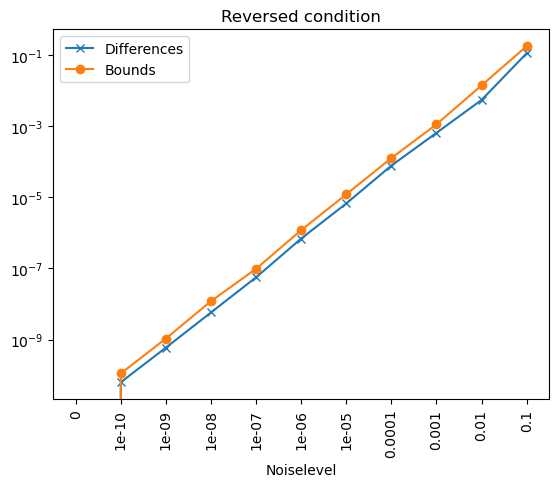

In [10]:
plt.title("Reversed condition")
plt.plot(differences,marker='x',label="Differences")
plt.plot(bounds,marker='o',label="Bounds")
plt.xticks(np.arange(len(noise_levels)),noise_levels,rotation=90)
plt.yscale('log')
plt.xlabel('Noiselevel')
plt.legend()

### Reversed condition: Threshold

If a matrix $A$ is singular ($\sigma_n=0$) we have
$$ \frac{\tilde{\sigma}_n}{\tilde{\sigma}_1} \leq \frac{\epsilon}{C-\epsilon}\sqrt{ 1+\frac{\epsilon}{C-\epsilon}^2 }$$
for $C\leq \sigma_1$ and $\epsilon \geq \|E\|_F$.
If a matrix $A$ is non singular ($\sigma_n>0$) we have
$$\frac{\tilde{\sigma}_n}{\tilde{\sigma}_1} \geq \frac{\sigma_n-\epsilon}{\sigma_1+\epsilon} \geq \frac{C_2-\epsilon}{C_1+\epsilon}$$
for $C_2 \leq\sigma_n,  \sigma_1 \leq C_1$

In [253]:
"""
This function should upper bound the reversed condition for singular matrices 
where on>C2>0
C1:lower bound of biggest singular value: C <= o_max
eps: lower obund for frobenius norm of error matrix |E|_F <= eps
"""
def upper_bound_singular_matrix(C,eps):
    if C-eps<=0:
        print(f"Error is too big C<eps with C = {C:.3e}, eps = {eps:.3e}: no upper bound can be calculated")
        return 1.0
        
    bound= eps/(C-eps)*np.sqrt(1+(eps/(C-eps))**2) 
    bound = min(bound, 1.0) # o_min/o_max <=1 in all cases
    return bound

"""
This function should lower bound the reversed condition for nonsingular matrices 
where on>C2>0
C1: upper bound for o1 < C1
C2: lower bound for on > C2 > 0
eps: lower obund for frobenius norm of error matrix |E|_F <= eps
The question is how to choose C2??
"""
def lower_bound_nonsingular_matrix(C1,C2,eps):
    bound= (C2-eps)/(C1+eps)
    bound = max(bound,1e-10)
    return bound

In [254]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -1,2
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
print(alpha)
#matrix[:,0] = alpha*matrix[:,2]
print(matrix)
sv = svd(matrix, compute_uv=False)
sv_max = sv[0]
sv_min = sv[-1]
print(f"matrix shape: {matrix.shape}, rank: {matrix_rank(matrix)}" )
print(f"Singular values : {sv}" )
print(f"Smallest/Biggest singular value: {sv[-1]/sv[0]}")

0.08605255760062747
[[ 0.00962677  1.26007497  0.76906228]
 [-0.60352023 -0.07918112 -0.84076311]
 [ 0.91706017  0.40010394 -0.63824703]
 [-0.2437691   1.78723613 -0.41042784]
 [ 0.27299559  0.57218698 -0.6512034 ]
 [ 0.46507628 -0.22728146  1.15205284]
 [-0.23554996  0.09538016  0.41810733]
 [ 0.97473592 -0.03284326 -0.66960286]
 [ 0.60943946 -0.98072199  1.79764576]
 [ 0.55564501  1.64483847  1.03520202]]
matrix shape: (10, 3), rank: 3
Singular values : [3.07478983 2.9046492  1.70490415]
Smallest/Biggest singular value: 0.5544782735976307


In [255]:
# C values for second threshold
C=sv_max #<=sv_max
C1=sv_max#9 #>=sv_max
C2=1e-8#<=sv_min

In [256]:
noise_levels = [10**(-10+i) for i in range(0,9)]
print("Noise level \t ratio \t \t Upper bound \t Lower bound")
ratios =[]
upper_bounds =[]
lower_bounds =[]
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    ratio = sv[-1]/sv[0]
    # Do an educated guess for C and C1
    #C=sv[0] -np.linalg.norm(noise) 
    #C2=sv[-1] + np.linalg.norm(noise) 
    
    ratios.append(ratio)
    upper_bound = upper_bound_singular_matrix(C,np.linalg.norm(noise))
    upper_bounds.append(upper_bound)
    lower_bound = lower_bound_nonsingular_matrix2(C1,C2,np.linalg.norm(noise))
    lower_bounds.append(lower_bound)
    print(f" {target_noise}\t \t {ratio:3.3e}  \t {upper_bound:3.3e} \t {lower_bound:3.3e}")

Noise level 	 ratio 	 	 Upper bound 	 Lower bound
 1e-10	 	 5.545e-01  	 1.243e-10 	 3.128e-09
 1e-09	 	 5.545e-01  	 1.491e-09 	 1.761e-09
 1e-08	 	 5.545e-01  	 1.537e-08 	 1.000e-10
 1e-07	 	 5.545e-01  	 1.577e-07 	 1.000e-10
 1e-06	 	 5.545e-01  	 1.218e-06 	 1.000e-10
 1e-05	 	 5.545e-01  	 1.257e-05 	 1.000e-10
 0.0001	 	 5.545e-01  	 1.381e-04 	 1.000e-10
 0.001	 	 5.546e-01  	 1.283e-03 	 1.000e-10
 0.01	 	 5.545e-01  	 1.317e-02 	 1.000e-10


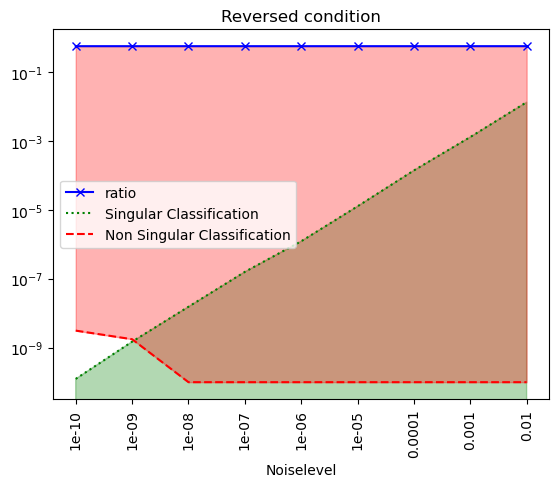

In [257]:
plt.title("Reversed condition")
plt.plot(ratios,marker='x',label="ratio",color='blue')
plt.plot(upper_bounds,':',label="Singular Classification",color='green')
plt.plot(lower_bounds,'--',label="Non Singular Classification",color='red')
plt.fill_between(np.arange(len(noise_levels)), upper_bounds,color='green', alpha=0.3)
plt.fill_between(np.arange(len(noise_levels)), lower_bounds, y2=np.max(ratios), color='red', alpha=0.3)
plt.xticks(np.arange(len(noise_levels)),noise_levels,rotation=90)
plt.yscale('log')
plt.xlabel('Noiselevel')
plt.legend()

### Reversed Condition: Threshold on concrete data

Denote the singular value of $\tilde{G}=G+E$ by  $\tilde{\sigma}_n$ where $G=(u|u_x)$. Furthermore, let $E \geq \|G-\tilde{G}\|_F$.

If the PDE is non unique, then $G$ is singular ($\sigma_n=0$) and we have
$$ \frac{\tilde{\sigma}_n}{\tilde{\sigma}_1} \leq \frac{E}{C-E}\sqrt{ 1+\frac{E}{C-E}^2 }$$
for $C\leq \sigma_1$.

If the PDE is unique,then $G$ is non singular ($\sigma_n>0$) and we have
$$\frac{\tilde{\sigma}_n}{\tilde{\sigma}_1} \geq \frac{\sigma_n-E}{\sigma_1+E} \geq \frac{C_2-E}{C_1+E}$$
for $0 <C_2 \leq \sigma_n,  \sigma_1 \leq C_1$. Note we need to have a valid approximation for a reasonable choice for $C_2$.

Note, here $E$ is the upper bound on the error caused by finite differences
$$E = \sqrt{ m(C_m \frac{\|u-\tilde{u}\|_{\infty}}{h} + h^{order} M C_a)^2 + \|u-\tilde{u}\|_2^2 }$$
However, since in practice we won't know all of these constands we can buest guess $E$ by guessing the maximal error $\epsilon \geq \|u-\tilde{u}\|_{\infty}$ and choosing
$$E =\frac{\epsilon}{h} + h^{order} $$

In [279]:
"""Threshold if values are beneath classify as non unique PDE
E: upper bound on the frobenius  |g-g_noise|_frobenius <=E where g =(u|u_x|...)
C: lower bound of biggest singular value: C <= o_max
"""
def calc_threshold_nonuniq(E,C):
    T = upper_bound_singular_matrix(C,E)
    return T
"""Threshold if values are above classify as unique PDE
E: upper bound on the frobenius  |g-g_noise|_frobenius <=E where g =(u|u_x|...)
C1: upper bound of biggest singular value: C1 => o_max
C2: upper bound of biggest singular value: C2 <= o_max
"""
def calc_threshold_uniq(C1,C2,E):
    T = lower_bound_nonsingular_matrix(C1,C2,E)
    return T

In [274]:
n_samples=100
T,X,t,x = create_data_2d(T_start=0, T_end=1, L_x_start=-2,L_x_end=3, N_t=n_samples, N_x=n_samples)
a=np.random.randn()*1e-6
b=np.random.randn()*1e-3
C=0.1
"""
u = np.cos(X-a*T)*C
ux = -np.sin(X-a*T)*C
uxx = -np.cos(X-a*T)*C
uxxx = np.sin(X-a*T)*C
ut = a*np.sin(X-a*T)*C


u=(X+b*T)*np.exp(a*T)
ux = np.exp(a*T)
uxx= 1
uxxx= 0
ut= b*np.exp(a*T) + a*(X*+b*T)*np.exp(a*T) #bux + aut
"""

u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

dx=x[1]-x[0]

In [275]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_min/sv_max:3.3e}")

M: 20.085564945861126
Singular values of g: (916.3938320669538, 3.1585421448149424e-14)
sv_max/sv_min: 3.447e-17


In [276]:
# Choose C,C1,C2
C=sv_max #<=sv_max
C1=sv_max+4 #>=sv_max
C2=1e-02#<=sv_min -> Essentially this boils down to the original problem  of knowing when sv_min is too small to classify the PDE as unique
print(f"For Non-Uniquness: \t \t C = {C:.3e} <= {sv_max:.3e} = sv_max")
print(f"For Uniqueness: \t C1 = {C1:.3e} >= {sv_max:.3e} = sv_max")
print(f"\t \t \t C2 = {C2:.3e} <= {sv_min:.3e} = sv_min")

For Non-Uniquness: 	 	 C = 9.164e+02 <= 9.164e+02 = sv_max
For Uniqueness: 	 C1 = 9.204e+02 >= 9.164e+02 = sv_max
	 	 	 C2 = 1.000e-02 <= 3.159e-14 = sv_min


0.0
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.01268035   6.7503468 ] 	 7.290e-03 	 1.000e-10 	 1.844e-02
2 	 [9.16533908e+02 1.67953200e-01] 	 1.832e-04 	 1.000e-10 	 3.376e-04
3 	 [9.16388814e+02 3.99734592e-03] 	 4.362e-06 	 1.007e-06 	 9.901e-06
4 	 [9.16393711e+02 1.54851134e-04] 	 1.690e-07 	 1.056e-05 	 3.037e-07
5 	 [9.16393832e+02 7.48577516e-06] 	 8.169e-09 	 1.085e-05 	 1.155e-08
6 	 [9.16393832e+02 3.00422825e-07] 	 3.278e-10 	 1.086e-05 	 4.682e-10
7 	 [9.16393832e+02 1.21679701e-08] 	 1.328e-11 	 1.086e-05 	 1.998e-11
8 	 [9.16393832e+02 5.67057769e-10] 	 6.188e-13 	 1.086e-05 	 9.206e-13
9 	 [9.16393832e+02 6.40172898e-11] 	 6.986e-14 	 1.086e-05 	 1.023e-13


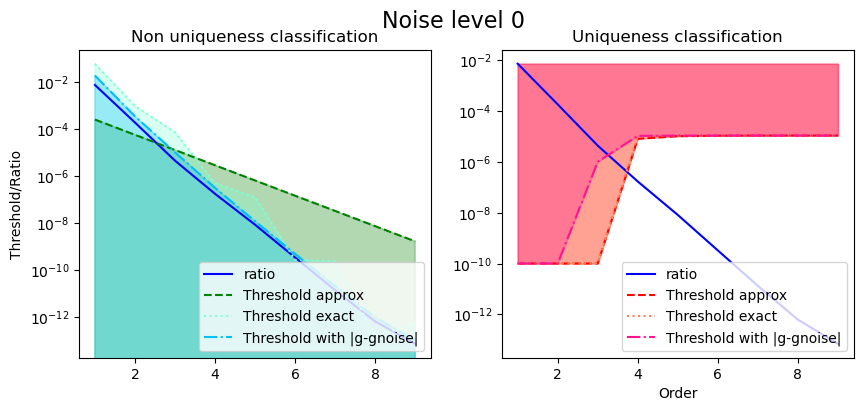

6.518728021217092e-08
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.01268036   6.75034679] 	 7.290e-03 	 1.000e-10 	 1.844e-02
2 	 [9.16533908e+02 1.67953183e-01] 	 1.832e-04 	 1.000e-10 	 3.376e-04
3 	 [9.16388814e+02 3.99735274e-03] 	 4.362e-06 	 1.007e-06 	 9.901e-06
4 	 [9.16393711e+02 1.54878045e-04] 	 1.690e-07 	 1.056e-05 	 3.038e-07
5 	 [9.16393832e+02 7.69610838e-06] 	 8.398e-09 	 1.085e-05 	 1.187e-08
6 	 [9.16393832e+02 1.99891058e-06] 	 2.181e-09 	 1.086e-05 	 3.087e-09
7 	 [9.16393832e+02 2.86015366e-06] 	 3.121e-09 	 1.086e-05 	 4.410e-09
8 	 [9.16393832e+02 4.31333138e-06] 	 4.707e-09 	 1.086e-05 	 6.658e-09
9 	 [9.16393832e+02 6.95301221e-06] 	 7.587e-09 	 1.085e-05 	 1.073e-08


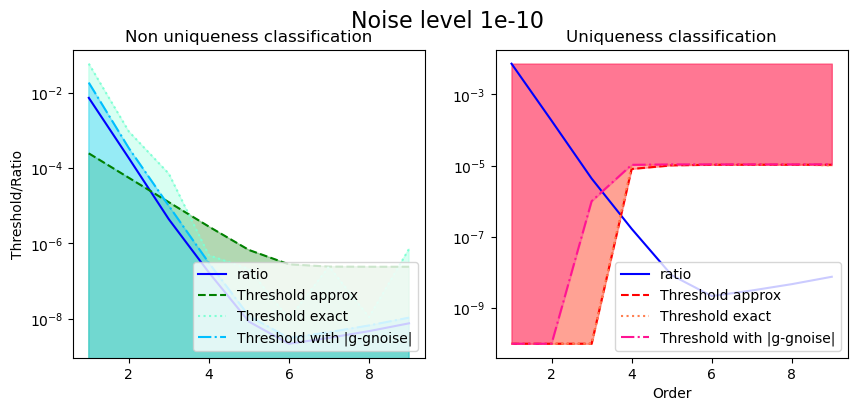

6.509993320899706e-07
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.01268046   6.75034661] 	 7.290e-03 	 1.000e-10 	 1.844e-02
2 	 [9.16533908e+02 1.67952857e-01] 	 1.832e-04 	 1.000e-10 	 3.376e-04
3 	 [9.16388814e+02 3.99709564e-03] 	 4.362e-06 	 1.008e-06 	 9.900e-06
4 	 [9.16393711e+02 1.54863225e-04] 	 1.690e-07 	 1.056e-05 	 3.036e-07
5 	 [9.16393832e+02 1.67166030e-05] 	 1.824e-08 	 1.084e-05 	 2.567e-08
6 	 [9.16393832e+02 1.87530801e-05] 	 2.046e-08 	 1.084e-05 	 2.893e-08
7 	 [9.16393832e+02 2.78676529e-05] 	 3.041e-08 	 1.082e-05 	 4.295e-08
8 	 [9.16393832e+02 4.33644482e-05] 	 4.732e-08 	 1.080e-05 	 6.693e-08
9 	 [9.16393830e+02 7.19812723e-05] 	 7.855e-08 	 1.075e-05 	 1.111e-07


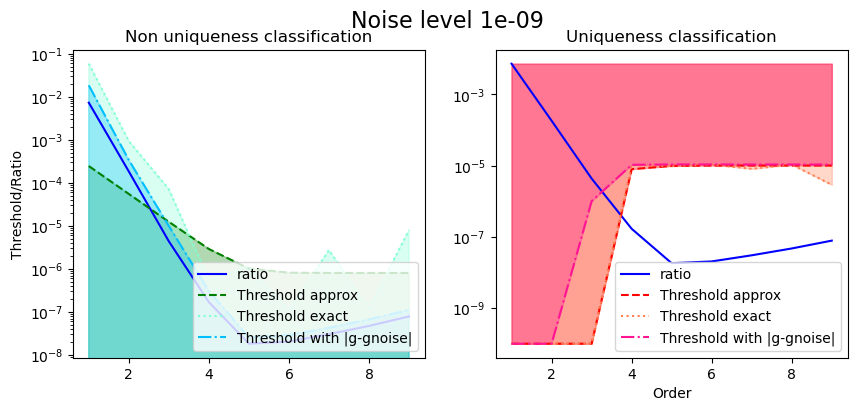

6.497178084402348e-06
order 	 singular values 	 ratio 	 Threshold uniq 	 Threshold non-uniq 
1 	 [926.01268071   6.75034619] 	 7.290e-03 	 1.000e-10 	 1.844e-02
2 	 [9.16533909e+02 1.67951403e-01] 	 1.832e-04 	 1.000e-10 	 3.376e-04
3 	 [9.16388815e+02 3.99516778e-03] 	 4.360e-06 	 1.010e-06 	 9.898e-06
4 	 [9.16393712e+02 1.82708803e-04] 	 1.994e-07 	 1.053e-05 	 3.369e-07
5 	 [9.16393836e+02 1.49656988e-04] 	 1.633e-07 	 1.064e-05 	 2.296e-07
6 	 [9.16393839e+02 1.90466708e-04] 	 2.078e-07 	 1.057e-05 	 2.940e-07
7 	 [9.16393844e+02 2.86527802e-04] 	 3.127e-07 	 1.042e-05 	 4.419e-07
8 	 [9.16393852e+02 4.50856065e-04] 	 4.920e-07 	 1.017e-05 	 6.964e-07
9 	 [9.16393866e+02 7.56845587e-04] 	 8.259e-07 	 9.701e-06 	 1.169e-06


In [ ]:
M=infinity_norm(uxxx)
number_noise=9 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(1,10,1)
unorm2=np.sqrt(np.mean(np.square(u)))

for target_noise in noise_levels:    
    threshold_uniq_list = []
    threshold2_uniq_list = []
    threshold3_uniq_list = []
    threshold_nonunique_list = []
    threshold2_nonunique_list = []
    threshold3_nonunique_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)
    print(f"order \t singular values \t ratio \t Threshold uniq \t Threshold non-uniq ")
    for order in orders:        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        
        
        ratio=sv[-1]/sv[0]

        #Potential upper bounds for |G-G_noise| 
        E1=np.sqrt(eps_infty/dx+dx**order)
        E2 = np.sqrt(error_bound_g(eps_two,eps_infty,dx,true_g.shape[0],M,order))
        E3 = np.linalg.norm(true_g-g_noise)
        
        threshold_uniq =  calc_threshold_uniq(C1,C2,E1)
        threshold2_uniq =  calc_threshold_uniq(C1,C2,E2)
        threshold3_uniq =  calc_threshold_uniq(C1,C2,E3)
        threshold_uniq_list.append(threshold_uniq)
        threshold2_uniq_list.append(threshold2_uniq)
        threshold3_uniq_list.append(threshold3_uniq)

  
        threshold_nonunique = calc_threshold_nonuniq(E1,C)
        threshold2_nonunique = calc_threshold_nonuniq(E2,C)
        threshold3_nonunique = calc_threshold_nonuniq(E3,C)
        threshold_nonunique_list.append(threshold_nonunique)
        threshold2_nonunique_list.append(threshold2_nonunique)
        threshold3_nonunique_list.append(threshold3_nonunique)
        
        print(f"{order} \t {sv} \t {ratio:.3e} \t {threshold3_uniq:.3e} \t {threshold3_nonunique:.3e}")
        ratio_list.append(ratio)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
    fig.suptitle(f'Noise level {target_noise}', fontsize=16)
    
    # Subplot 1: ratio and green lines
    ax1.set_title("Non uniqueness classification")
    ax1.plot(orders, ratio_list, label='ratio', color='blue')
    ax1.plot(orders, threshold_nonunique_list, '--', label='Threshold approx', color='green')
    ax1.plot(orders, threshold2_nonunique_list, ':', label='Threshold exact', color='aquamarine')
    ax1.plot(orders, threshold3_nonunique_list, '-.', label='Threshold with |g-gnoise|', color='deepskyblue')
    ax1.fill_between(orders, threshold_nonunique_list, color='green', alpha=0.3)
    ax1.fill_between(orders, threshold2_nonunique_list, color='aquamarine', alpha=0.3)
    ax1.fill_between(orders, threshold3_nonunique_list, color='deepskyblue', alpha=0.3)
    ax1.set_yscale('log')
    ax1.set_ylabel('Threshold/Ratio')
    
    # Subplot 2: ratio and red lines
    ax2.set_title("Uniqueness classification")
    ax2.plot(orders, ratio_list, label='ratio', color='blue')
    ax2.plot(orders, threshold_uniq_list, '--', label='Threshold approx', color='red')
    ax2.plot(orders, threshold2_uniq_list, ':', label='Threshold exact', color='coral')
    ax2.plot(orders, threshold3_uniq_list, '-.', label='Threshold with |g-gnoise|', color='deeppink')
    ax2.fill_between(orders, threshold_uniq_list, y2=np.max(ratio_list), color='red', alpha=0.3)
    ax2.fill_between(orders, threshold2_uniq_list, y2=np.max(ratio_list), color='coral', alpha=0.3)
    ax2.fill_between(orders, threshold3_uniq_list, y2=np.max(ratio_list), color='deeppink', alpha=0.3)
    ax2.set_yscale('log')

    
    ax2.set_xlabel('Order')
    ax1.legend(loc=4)
    ax2.legend(loc=4)
    
    plt.show()
    

In [278]:
threshold2_nonunique_list

[0.1911571237130035,
 0.055315172230480596,
 0.5881793480123606,
 0.08384281823294208,
 1.0,
 0.10461002162018923,
 1.0,
 0.1207971718683673,
 1.0]

We assume $\sigma_n=0$. Denote the singular value of $\tilde{A}=A+E$ by  $\tilde{\sigma}_n$ and $G=(u|u_x)$.
 $$\frac{\tilde{\sigma}_n}{\|\tilde{G}\|_F} \leq \frac{\sigma_n + \|G-\tilde{G}\|_F}{\|\tilde{G}\|_F} \leq  \frac{ \sqrt{C}}{\|\tilde{G}\|_F} = T_1$$
where $C = m(C_m \frac{\epsilon}{h} + h^{order} M C_a)^2 + \|u-\tilde{u}\|_2^2$ and $\epsilon = \|u-u_{noise}\|_{\infty} + 10^{-16}$ and $h=dx$. If a value is smaller than T_1, the function u should be nonunique. Note in the following we also use the threshold
$$T_2= \frac{\frac{\epsilon}{h} + h^{order} }{\|\tilde{G}\|_F}$$
where we ignore all constants and guess \epsilon, since we can not know these in practice.